In [1]:
import _utils.helper as hlp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# parametaers

In [2]:
from keras import optimizers

h_params = {}

# test, train, validation
h_params['samples_count'] = 301849 # max for balance --> 301849
h_params['samples_are_balanced'] = True
h_params['train_split'] = .8
h_params['validation_split'] = .2
h_params['pretrained_vec'] = None #'my_embedding 50' #'my_embedding 32' # 'glove 50' 'glove 100' 'glove 300'  # None means no pretrained used # 'my_embedding 100' means get embedding layer of trained model

# text
h_params['max_words'] = 30000
h_params['maxlen'] = 900
h_params['embedding_dim'] = 50 if h_params['pretrained_vec'] == None else int(h_params['pretrained_vec'].split()[1])

# fit
h_params['epochs'] = 5
h_params['batch_size'] = 128

# compile
h_params['learning_rate'] = 1e-3 # defult 1e-3
h_params['optimizer'] = optimizers.Adam(learning_rate=h_params['learning_rate']) # optimizers.RMSprop(lr=h_params['learning_rate'])
h_params['metrics'] = ['acc']

merge_my_embedding__pretrained_vec = False
data_path = './_imported_data'
models_path = './models/samples_300k'
my_embedding_filename = 'empty' #'15806_7_7_3_35_Conv1D_CuDNNLSTM_7769_50vec.embedding' #'15805_5_2_6_41_Conv1D_LSTM_77.2'

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## laod data

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#data_reviews = hlp.load('./_imported_data/action_preprocessed_' + str(h_params['max_words']))
#data_reviews = hlp.load('./_imported_data/all_genres_preprocessed_' + str(h_params['max_words']))
#data_reviews = hlp.load('./_imported_data/all_genres_preprocessed_' + str(h_params['max_words']))
data_reviews = hlp.load(data_path + '/' + 'all_genres_preprocessed_' + str(h_params['max_words']) + '_balanced' if h_params['samples_are_balanced'] else '')

df_reviews = data_reviews['df']
tokenizer = data_reviews['tokenizer']

# shuffle data
df_reviews = df_reviews.sample(frac=1, random_state=1)

# cutt data
df_reviews = df_reviews[:h_params['samples_count']]

data_reviews.keys()

dict_keys(['df', 'tokenizer'])

In [4]:
df_reviews

,post_id,sequence,is_spoiler
187016,1187016,"[226, 118, 395, 3, 433, 163, 15, 238, 7, 51, 1...",0
282924,1282924,"[230, 130, 3620, 7437, 7796, 8581, 169, 4515, ...",1
355827,1355827,"[82, 620, 245, 813, 79, 23, 249, 4, 586, 2082,...",1
34298,1034298,"[343, 56, 13359, 11, 33, 6951, 10, 8, 209, 3, ...",0
460982,1460982,"[11, 6, 36, 32, 27, 4, 5843, 1148, 168, 80, 3,...",1
...,...,...,...
88009,1088009,"[52, 48, 79, 23, 117, 219, 6, 3412, 57, 7, 3, ...",1
436698,1436698,"[1, 5131, 1, 5131, 1, 5131, 1191, 40, 140, 3, ...",1
248719,1248719,"[235, 5, 323, 70, 4, 1, 1031, 155, 9, 6, 991, ...",1
159030,1159030,"[1814, 1954, 4353, 2120, 1621, 3, 834, 540, 4,...",0


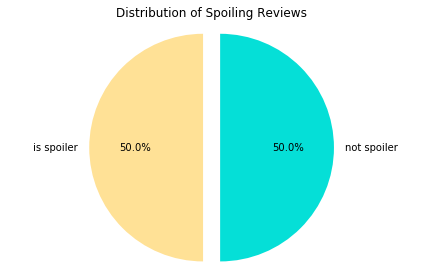

,is_spoiler,count
0,true,150924
1,false,150924


In [5]:
false , true = df_reviews.is_spoiler.value_counts()

labels = ['is spoiler', 'not spoiler']
values = [true, false]

# Create a list of colors (from iWantHue)
colors = ["#ffe196", "#05dfd7"]

tmpdf = pd.DataFrame({'is_spoiler':['true', 'false'], 'count': values})
tmpdf.set_index('is_spoiler')

plt.pie(
    # using data total)arrests
    tmpdf['count'],
    # with the labels being officer names
    labels=labels,
    # with colors
    colors=colors,
    # with no shadows
    shadow=False,
    # with one slide exploded out
    explode=(0, 0.15),
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%');
plt.title('Distribution of Spoiling Reviews')   
# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

tmpdf

In [6]:
list_of_review_lens = [len(i) for i in df_reviews['sequence'].tolist()]
print('min: {} \t max: {} \t mean: {} \t mdian: {}'.format(min(list_of_review_lens), max(list_of_review_lens), round(np.mean(list_of_review_lens)),  np.median(list_of_review_lens)))

min: 0 	 max: 2704 	 mean: 289.0 	 mdian: 215.0


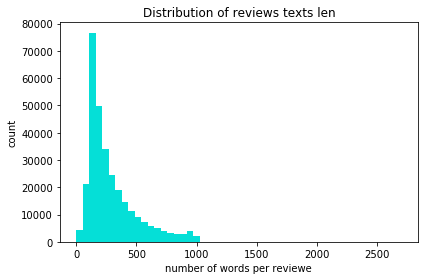

In [7]:
#plt.xticks = range(100)
counts, bins = np.histogram(list_of_review_lens)
plt.hist(list_of_review_lens, bins=50, color='#05dfd7')
#plt.hist(bins[:-1], bins, weights=counts)
plt.title('Distribution of reviews texts len')  
plt.xlabel('number of words per reviewe')
plt.ylabel('count')
# View the plot
plt.tight_layout()
plt.show()

## padding

In [8]:
paded_sequences = pad_sequences(df_reviews['sequence'].tolist(), maxlen=h_params['maxlen'])

## x_train y_trian

In [9]:
train_len = int(df_reviews['sequence'].count()*h_params['train_split'])
x_train = paded_sequences[:train_len]
y_train = df_reviews['is_spoiler'].tolist()[:train_len]

x_test = paded_sequences[train_len:]
y_test = df_reviews['is_spoiler'].tolist()[train_len:]

len(x_train)

241478

## accuricy check random on all

In [10]:
import copy
test_labels_copy = copy.copy(df_reviews['is_spoiler'].tolist())
np.random.shuffle(test_labels_copy)
hits_array = np.array(df_reviews['is_spoiler'].tolist()) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(df_reviews['is_spoiler'].tolist())

0.5004174286395802

## accuricy check on test with all not spoiler

In [11]:
hits_array = np.array(y_test) == np.zeros(len(y_test), dtype=int)
float(np.sum(hits_array)) / len(y_test)

0.5033294682789465

In [12]:
len(df_reviews['is_spoiler'].tolist())

301848

# ***

## pretrained

In [13]:
from os.path import exists, join
from os import makedirs

# make dir
pretrained_path = './_pretrained_vec'
if not exists(pretrained_path): makedirs(pretrained_path)

In [14]:
if h_params['pretrained_vec'] != None:
    if 'glove' in h_params['pretrained_vec']:

        # load GloVe
        glove_dir = join(pretrained_path,'glove.6B')
        embeddings_index = {}
        f = open(join(glove_dir, 'glove.6B.{}d.txt'.format(h_params['pretrained_vec'].split()[1])), encoding='utf-8')
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print('Found %s word vectors.' % len(embeddings_index))

        # creating embedding matrix
        embedding_matrix = np.zeros((h_params['max_words'], h_params['embedding_dim']))
        for word, i in tokenizer.word_index.items():
            if i < h_params['max_words']:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
        print(embedding_matrix.shape)
        
    elif 'my_embedding' in h_params['pretrained_vec']:
        embedding_matrix = hlp.load(join(models_path, my_embedding_filename))
        embedding_matrix = np.array(embedding_matrix)[0]
        print(embedding_matrix.shape)
    else: print('Error!! pretrained vectors not found!!!')
else: print('no pretrained vector used!')        

(30000, 50)


In [15]:
if merge_my_embedding__pretrained_vec:
    if h_params['pretrained_vec'] == None: 
        print('ERROR!!! no pretrained vector assigned!!!')
    else:        
        # load my embedding
        my_embedding_matrix = hlp.load(join(models_path, my_embedding_filename))
        my_embedding_matrix = np.array(my_embedding_matrix)[0]

        # merge embedings
        embedding_matrix = embedding_matrix + 3*my_embedding_matrix

# ***

## Model

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, SimpleRNN, Dropout, CuDNNLSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, MaxPooling1D

model = Sequential()
model.add(Embedding(h_params['max_words'], h_params['embedding_dim'], input_length=h_params['maxlen']))

if h_params['pretrained_vec'] != None:
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

In [17]:
#model = Sequential()
#model.add(Embedding(h_params['max_words'],
#            h_params['embedding_dim'],
#            input_length=h_params['maxlen']))
###########################
## inner section ##########
###########################
#model.compile(optimizer=h_params['optimizer'],
#                loss='binary_crossentropy',
#                metrics=h_params['metrics'])

### middel arch

In [18]:
#model.add(Flatten())
#model.add(Dense(32, activation='relu'))

In [19]:
#model.add(Flatten())
#model.add(Dropout(.5))
#model.add(Dense(32, activation='relu'))

In [20]:
#model.add(Flatten())
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(.5))

In [21]:
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(.5))

In [22]:
#model.add(Dropout(.2))
#model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(.5))
#model.add(Dense(32, activation='relu'))

In [23]:
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(64, activation='relu'))

In [24]:
#model.add(Flatten())
#model.add(Dropout(.4))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(.2))

In [25]:
#model.add(Flatten())
#model.add(Dropout(.4))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(.2))

In [26]:
#model.add(Flatten())
#model.add(Dropout(.5))
#model.add(Dense(32, activation='tanh'))
#model.add(Dropout(.2))

In [27]:
#model.add(Flatten())
#model.add(Dropout(.5))
#model.add(Dense(64, activation='tanh'))
#model.add(Dropout(.2))

#### ---

In [28]:
#model.add(SimpleRNN(32))

In [29]:
#model.add(SimpleRNN(64))

In [30]:
#model.add(SimpleRNN(32, return_sequences=True))
#model.add(SimpleRNN(32))

#### ---

In [31]:
#model.add(LSTM(32))

In [32]:
#model.add(CuDNNLSTM(32))

In [33]:
#model.add(CuDNNLSTM(32))
#model.add(Dropout(rate=0.2))

In [34]:
#model.add(CuDNNLSTM(128))
#model.add(Dropout(rate=0.2))

In [35]:
#from keras.regularizers import l2

#model.add(CuDNNLSTM(32, kernel_regularizer=l2(0.001)))
#model.add(Dropout(rate=0.3))

In [36]:
#from keras.regularizers import l1_l2

#model.add(CuDNNLSTM(32, kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
#model.add(Dropout(rate=0.2))

In [37]:
#model.add(Bidirectional(CuDNNLSTM(32)))
#model.add(Dropout(rate=0.2))

In [38]:
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
#model.add(GlobalMaxPooling1D())
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))                 

In [39]:
#model.add(Dropout(0.2))
#model.add(Conv1D(128, 5, padding='valid', activation='relu', strides=1))
#model.add(GlobalMaxPooling1D())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))   

In [40]:
#model.add(Dropout(0.2))
#model.add(Conv1D(32, 5, padding='valid', activation='relu', strides=1))
#model.add(MaxPooling1D(3))
#model.add(Conv1D(32, 5, padding='valid', activation='relu', strides=1))                 
#model.add(GlobalMaxPooling1D())
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))   

In [41]:
#model.add(Dropout(0.25))
#model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=4))
#model.add(CuDNNLSTM(64))

In [42]:
#model.add(Dropout(0.25))
#model.add(Conv1D(128, 5, padding='valid', activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=4))
#model.add(CuDNNLSTM(90))

In [43]:
#model.add(Dropout(0.25))
#model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=4))
#model.add(CuDNNLSTM(70))

In [44]:
#model.add(Dropout(0.25))
#model.add(Conv1D(64, 5, activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=3))
#model.add(Conv1D(64, 5, activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=3))
#model.add(CuDNNLSTM(90))

In [45]:
#model.add(Dropout(0.25))
#model.add(Conv1D(128, 5, activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=3))
#model.add(Conv1D(128, 5, activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=3))
#model.add(CuDNNLSTM(90))

In [46]:
#model.add(Dropout(0.25))
#model.add(Conv1D(256, 5, padding='valid', activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=3))
#model.add(Conv1D(256, 5, padding='valid', activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=3))
#model.add(CuDNNLSTM(128))

In [47]:
#model.add(Dropout(0.25))
#model.add(Conv1D(256, 5, padding='valid', activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=3))
#model.add(Conv1D(256, 5, padding='valid', activation='relu', strides=1))
#model.add(MaxPooling1D(pool_size=3))
#model.add(CuDNNLSTM(256))

In [48]:
#model.add(Dropout(rate=0.2))
#model.add(CuDNNLSTM(32))
#model.add(Dropout(rate=0.2))

In [49]:
#model.add(Dropout(rate=0.2))
#model.add(CuDNNLSTM(32, return_sequences=True))
#model.add(CuDNNLSTM(32))
#model.add(Dropout(rate=0.2))

### compile

In [50]:
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer=h_params['optimizer'], loss='binary_crossentropy', metrics=h_params['metrics'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 900, 50)           1500000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 900, 50)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5760128   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [51]:
#model.layers[0].trainable = True


Train on 193182 samples, validate on 48296 samples
Epoch 1/5
193182/193182 [==============================] - 56s 288us/step - loss: 0.5008 - acc: 0.7568 - val_loss: 0.5131 - val_acc: 0.7509
Epoch 2/5
193182/193182 [==============================] - 56s 289us/step - loss: 0.4686 - acc: 0.7767 - val_loss: 0.5148 - val_acc: 0.7510
Epoch 3/5
193182/193182 [==============================] - 56s 288us/step - loss: 0.4569 - acc: 0.7860 - val_loss: 0.5151 - val_acc: 0.7509
Epoch 4/5
193182/193182 [==============================] - 56s 288us/step - loss: 0.4430 - acc: 0.7942 - val_loss: 0.5325 - val_acc: 0.7418
Epoch 5/5
193182/193182 [==============================] - 56s 292us/step - loss: 0.4373 - acc: 0.7991 - val_loss: 0.5240 - val_acc: 0.7474
280
model file name is: 15806_8_1_5_09_LSTM
<function xlabel at 0x0000023BD0A29F78>


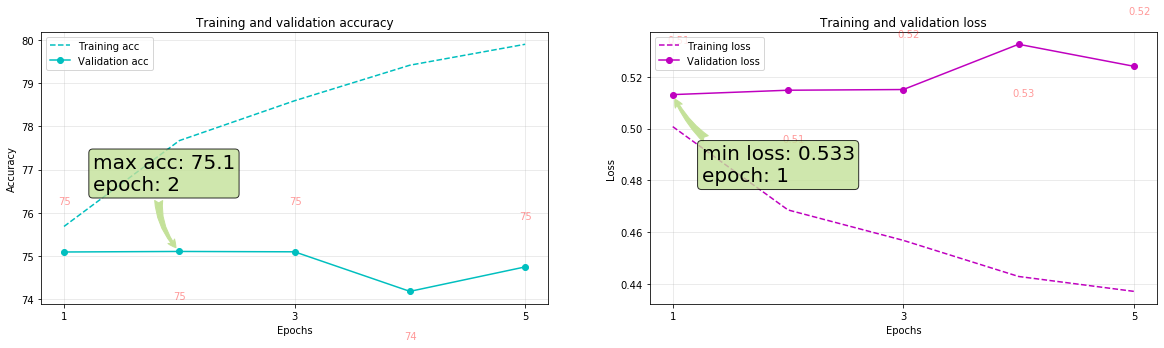

In [52]:
import time
#import tensorflow as tf
#with tf.device('/GPU:0'):
startt = time.time()

history = model.fit(x_train, y_train,
epochs=h_params['epochs'],
batch_size=h_params['batch_size'],
validation_split=h_params['validation_split'])

print(round(time.time() - startt))

# save model
model_h = {}
model_h['history'] = history
model_h['train_duration'] = round(time.time() - startt)
model_h['hyper_parameters'] = h_params
model_h['hyper_parameters']['optimizer'] = str(h_params['optimizer'])
filename = str(round(time.time()))
filename = '_'.join([filename[:5],
                    filename[5:6],
                    filename[6:7],
                    filename[7:8],
                    filename[8:],
                    'LSTM'])
from os.path import exists, join
from os import makedirs
models_path = './_models'
if(not exists(models_path)): makedirs(models_path)
hlp.save(model_h, join(models_path, filename))

# show result with plot
print('model file name is:', filename)
hlp.show_model_plot(model_h);

In [53]:
import subprocess
# pick an external mp3 player you have
sound_program = "C:\Program Files\DAUM\PotPlayer\PotPlayerMini64.exe"
# pick a sound file you have
sound_file = "beep4.wav"
subprocess.call([sound_program, sound_file])

0

In [54]:
#model.evaluate(x_test, y_test)